In [ ]:
# Colab specific setup
try:
  from google.colab import drive
  
except Exception:
  # Local setup
  rootpath = "."

else:
  drive.mount('/content/gdrive')
  rootpath = '/content/gdrive/MyDrive/T_ML/0-try1-13styles'

Mounted at /content/gdrive


In [ ]:
import os
os.chdir(rootpath)

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim
from torchvision import transforms as trn
import torchvision.models as models
import torch.utils.data as data

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

# 定义模型

In [ ]:
#加载的模型和之前训练的模型要一样，直接从前面的复制过来就好
model = models.densenet121(pretrained=True)
# 修改模型，与任务相关
model.classifier = nn.Linear(in_features=1024, out_features=13, bias=True)
# cuda 并行
model = nn.DataParallel(model).cuda()

# 加载优化器，也是和之前的一样，直接复制，损失函数不一定要了
# 定义优化器
optimizer = torch.optim.SGD(model.parameters(),
                            0.001, # learning rate 最重要的超参数之一
                            momentum = 0.9,
                            weight_decay = 1e-4)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 205MB/s]


In [ ]:
# 加载模型
######和之前a1中训练不一样的第一处
checkpoint = torch.load("best_checkpoint100.pth.tar")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

# 读取数据

In [ ]:
# 加载数据
dataDF = pd.read_pickle("13styles_v0.p")
evalDF = dataDF[dataDF['split']=='val']

In [ ]:
# 定义dataset类
# 创建数据集
class Dataset(data.Dataset):
    def __init__(self, imgPathList, labelList, transform):
        self.imgPathList = imgPathList
        self.labelList = labelList
        self.transform = transform
    def __getitem__(self, index):
        # 得到图片
        img_path = self.imgPathList[index]
        image = Image.open(img_path).convert("RGB")
        # 预处理图片
        image = self.transform(image)
        
        # 得到label
        label = self.labelList[index]
        
        return (image, label)
    def __len__(self):
        return len(self.labelList)
    
# 定义图像预处理
tf = trn.Compose([
    trn.Resize([224, 224]),
    trn.ToTensor(),
    trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
# 真正的数据集

evalDataset = Dataset(evalDF.path.tolist(), np.array(evalDF.label), tf)
evalLoader = data.DataLoader(evalDataset,
                            batch_size=16,  #可以和之前的不一样
                            ######和之前a1中训练不一样的第二处，改成了false
                            shuffle=False,  #改成false 方便保存结果
                            num_workers = 1)

In [ ]:
# 计算准确率
def accuracy(y_pred, y_true):
    batch_size = y_true.size(0)
    pred = y_pred.argmax(axis=1)
    correct = pred.eq(y_true)
    return correct.sum() / batch_size * 100

# 计分器
class AverageMeter(object):
    def __init__(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n):
        self.value = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# 评估函数
# 和之前train和validation差不多，更像validation

def evaluate():
    model.eval()
    accs = AverageMeter()
    #建两个列表，装表现
    y_preds = []
    y_trues = []
    #不更新参数
    with torch.no_grad():
        for i, (x, y_true) in enumerate(evalLoader):
            x = x.cuda()
            y_true = y_true.cuda()
            
            #计算结果
            y_pred = model(x)

            # 计算准确率，更关心准确率，loss不是很重要
            acc = accuracy(y_pred, y_true)
            accs.update(acc, y_true.size(0))

            # 存储结果
            y_preds.extend(y_pred.argmax(axis=1).cpu().numpy()) #Tensor变成一个正常的数值
            y_trues.extend(y_true.cpu().numpy())
    return accs, y_preds, y_trues

In [ ]:
evalAccs, preds, trues = evaluate()

In [ ]:
evalAccs.avg
# 73%的准确率

tensor(73.2601, device='cuda:0')

In [ ]:
evalDF['pred'] = preds
evalDF['trues'] = trues

<ipython-input-13-b976236982b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evalDF['pred'] = preds
<ipython-input-13-b976236982b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evalDF['trues'] = trues


In [ ]:
evalDF.head()

#训练集越大 这里越准确 这里是因为之前的训练集不够大所以不太准

,gid,label,split,path,pred,trues
1275,6-Chicago school architecture-94,6,val,/content/gdrive/MyDrive/T_ML/0-try1-13styles/n...,6,6
2050,9-Art Deco architecture-163,9,val,/content/gdrive/MyDrive/T_ML/0-try1-13styles/n...,9,9
517,2-Greek Revival architecture-137,2,val,/content/gdrive/MyDrive/T_ML/0-try1-13styles/n...,2,2
566,2-Greek Revival architecture-316,2,val,/content/gdrive/MyDrive/T_ML/0-try1-13styles/n...,2,2
2151,10-Brutalism-223,10,val,/content/gdrive/MyDrive/T_ML/0-try1-13styles/n...,10,10


In [ ]:
evalDF.to_pickle("13styles_modelEval100.p", protocol=3)

# 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cnf_matrix = confusion_matrix(evalDF['trues'], evalDF['pred'], normalize='true')

<Axes: >

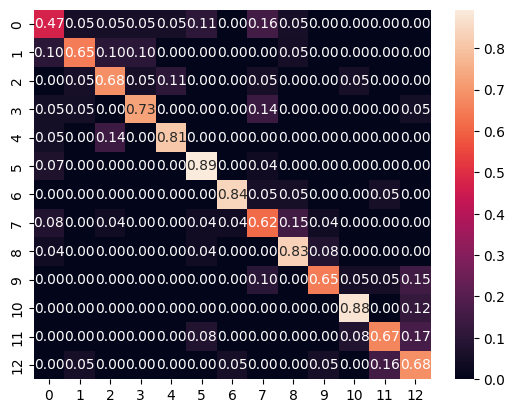

In [ ]:
#用seaborn来可视化矩阵
sns.heatmap(cnf_matrix, annot=True, fmt='.2f')